In [ ]:
import cv2
import torchvision.transforms as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [ ]:
# USE GPU IF AVAILABLE
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

In [67]:
def test(model, img):
    model.eval()
    # original_img = cv2.imread(image_file)

    if img is not None:
        print("Image loaded successfully!")
    else:
        print("Unable to load the image. Please check the file path.")

    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    model._modules.get('layer4').register_forward_hook(hook_feature)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_img = preprocess(img).unsqueeze(0).to(device)


    # Forward pass to get feature maps
    output = None
    with torch.no_grad():
        output = model(input_img)
    
    # print(predictions)
    # print(predictions[0])
    # classes = ['face', 'no face']
    predictions = F.softmax(output, dim=1).data.squeeze()
    print(f"Model predicts the image has a face with probability {predictions[0].item()}")

    params = list(model.parameters())
    weight = np.squeeze(params[-2].data.cpu().numpy())
    cam = weight[0].dot(features_blobs[0].reshape(-1, 7 * 7))

    cam = cam.reshape(7, 7)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0])) 

    # Apply heatmap on the original image
    heatmap = cv2.applyColorMap(255 - cam, cv2.COLORMAP_JET)

    return heatmap

Image loaded successfully!
Model predicts the image has a face with probability 0.9988131523132324


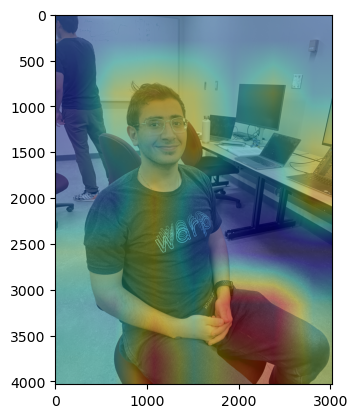

Image loaded successfully!
Model predicts the image has a face with probability 0.9991718530654907


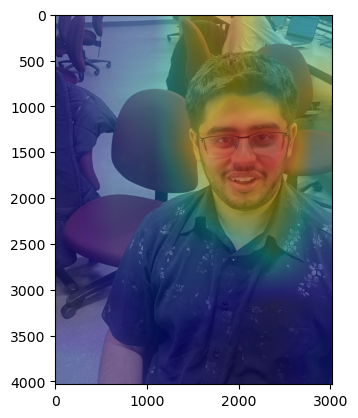

Image loaded successfully!
Model predicts the image has a face with probability 0.9999936819076538


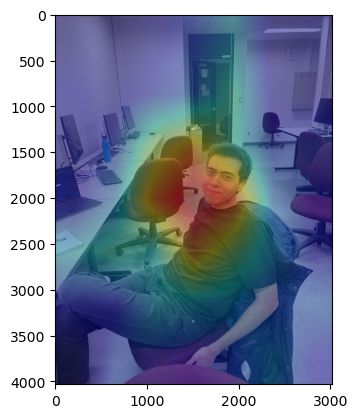

Image loaded successfully!
Model predicts the image has a face with probability 0.031155036762356758


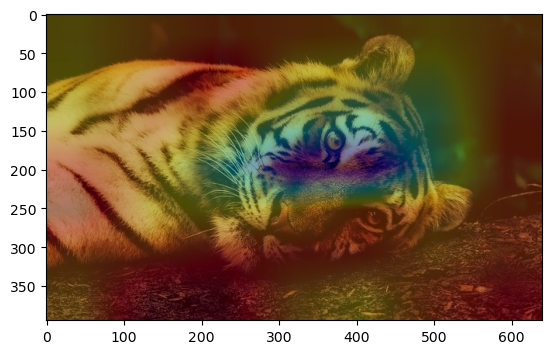

Image loaded successfully!
Model predicts the image has a face with probability 0.30808746814727783


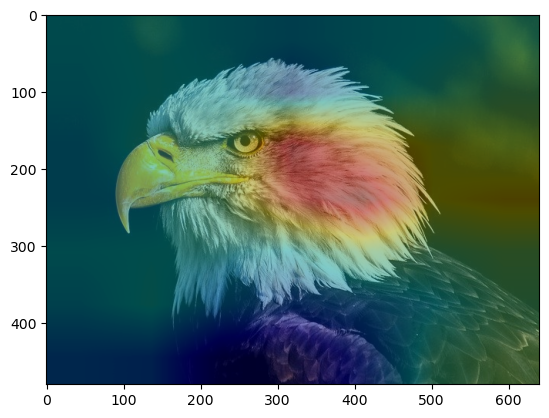

Image loaded successfully!
Model predicts the image has a face with probability 0.22495216131210327


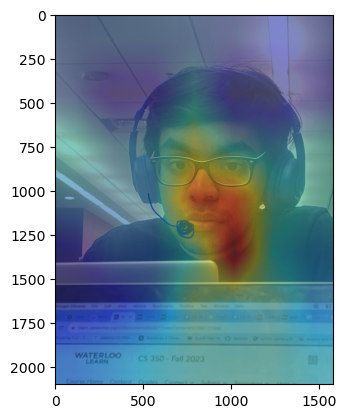

In [123]:
image_file = 'shahan.jpg'
# image_file = 'sat.png'
# image_file = 'osama.jpg'
# image_file = 'image_2.jpg'
# image_file = 'tejas.jpg'

images = ['shahan.jpg', 'sat.png', 'osama.jpg', 'image_1.jpg', 'image_2.jpg', 'tejas.jpg']
for image_file in images:
    original_img = cv2.imread(image_file)
    img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    # trained_model = torch.load('models/model_1_2023-12-20_17:15:35.pth') # good for eagle, shahan

    # trained_model = torch.load('models/model_2_2023-12-20_16:58:27.pth')
    # trained_model = torch.load('models/model_3_2023-12-20_17:43:02.pth') # best with flipped labels

    trained_model = torch.load('models/model_4_2023-12-20_17:52:31.pth')

    # trained_model = torch.load('model_1.pth')
    heatmap = test(trained_model, img)
    output_img = heatmap * 0.3 + img.astype('float32') * 0.5
    plt.imshow(output_img.astype('uint8'))
    plt.show()